# Stellar Blends Classification

### In this notebook we run the un-normalized and normalized datasets through the MuyGPyS classifier (a python classifying function that uses the MuyGPS  Gaussian process hyperparameter estimation method), and compare the resulting accuracies.

**Note:** Must have run `data_normalization.ipynb` to continue.

In [1]:
# from MuyGPyS import config
# config.update("muygpys_jax_enabled", False)

import numpy as np
import pandas as pd
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from MuyGPyS.examples.classify import do_classify
from MuyGPyS.gp.deformation import F2, Isotropy
from MuyGPyS.gp.hyperparameter import Parameter, Parameter as ScalarParam
from MuyGPyS.gp.kernels import RBF, Matern
from MuyGPyS.gp.noise import HomoscedasticNoise
from MuyGPyS.optimize import Bayes_optimize
from MuyGPyS.optimize.loss import LossFn, cross_entropy_fn



/home/eleh/miniconda3/envs/muygps/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


### Read in all flattened data (normalized and un-normalized):

In [2]:
from glob import glob

# read normalized data csv file names from the data directory
norm_data_names = glob('../data/data-norm/*.csv')
# get rid of "../data/data-norm/"
norm_data_names = [name.split('/')[-1] for name in norm_data_names]
norm_data_names[:2]

['norm_1_data.csv', 'nthroot_0.5862_data.csv']

In [3]:
# sort the names by their numbers
norm_data_names.sort(key=lambda x: x.split('_')[1])
norm_data_names[:2]

['nthroot_0.0_data.csv', 'nthroot_0.03448_data.csv']

### Define a function that generates "one-hot" values.

This essentially just takes our truth labels of 0 and 1, and does the following conversions for use in the classifier:
- 0 to [1., -1.]
- 1 to [-1., 1.]

In [4]:
def generate_onehot_value(values):
    onehot = []
    for val in values:
        if val == 0:
            onehot.append([1., -1.])
        elif val == 1:
            onehot.append([-1., 1.])
    return onehot

### Run the classifier on each dataset

For each dataset (un-normalized and normalized) in `data_files`, this for loop does the following:
- Separate labels from data
- Split up data between training and testing
    - `test_size` is the fraction of the data you want to use for testing, where 0.5 means half of the data is used for testing and half for training.
    - `random_state` makes each dataset get trained and tested on the same number of stars and galaxies.
- Gets the one-hot values for the testing and training labels
- Gets `train` and `test` into the proper format for the classifier, a dictionary with the keys: 
    - 'input': 
    - 'output':
    - 'lookup':
- Does the classification (`do_classify`)
- Computes the accuracy of the classifier for the given dataset, by compairing predicted labels to truth labels.

In [5]:
nn_kwargs_exact = {"nn_method": "exact", "algorithm": "ball_tree"}

nn_kwargs_hnsw = {"nn_method": "hnsw"}

k_kwargs_rbf ={
            "kernel": RBF(
                 deformation=Isotropy(
                     metric=F2,
                 length_scale=Parameter(1.0, (1e-2, 1e2)),
                 ),
            ),
            "noise": HomoscedasticNoise(1e-5),
            }
k_kwargs_mattern= { "kernel": Matern(
             smoothness=ScalarParam(0.5),
             deformation=Isotropy(
                 metric=F2,
                 length_scale=Parameter(1.0, (1e-2, 1e2)),
             ),
         ),
         "noise": HomoscedasticNoise(1e-5),
         }

In [6]:
# for path in norm_data_names:
#     path = '../data/data-norm/' + path
#     data = pd.read_csv(path,na_values='-')
#     data.fillna(0,inplace=True)
#     data_label = 'Normalized {} {}'.format(*path.split('_')[:2])
#     truth_labels = data.iloc[:, 0].values
#     image_data = data.iloc[:, 1:].values

#     X_train, X_test, y_train, y_test = train_test_split(image_data, truth_labels, test_size=0.2, random_state=42)

#     print("=============== ", data_label, " ===============")
#     print('Training data:', len(y_train[y_train==0]), 'single stars and', len(y_train[y_train==1]), 'blended stars')
#     print('Testing data:', len(y_test[y_test==0]), 'single stars and', len(y_test[y_test==1]), 'blended stars')

#     onehot_train, onehot_test = generate_onehot_value(y_train), generate_onehot_value(y_test)

#     train = {'input': X_train, 'output': onehot_train, 'lookup': y_train}
#     test = {'input': X_test, 'output': onehot_test, 'lookup': y_test}

#     print("Running Classifier on", data_label)
#     #Switch verbose to True for more output


#     muygps, nbrs_lookup, surrogate_predictions = do_classify(
#                                 test_features=np.array(test['input']), 
#                                 train_features=np.array(train['input']), 
#                                 train_labels=np.array(train['output']), 
#                                 nn_count=30,
#                                 batch_count=200,
#                                 loss_fn=cross_entropy_fn,
#                                 opt_fn=Bayes_optimize,
#                                 k_kwargs=k_kwargs_mattern,
#                                 nn_kwargs=nn_kwargs_hnsw,
#                                 verbose=False)
#     predicted_labels = np.argmax(surrogate_predictions, axis=1)
#     print("Total accuracy for", data_label, ":", np.around((np.sum(predicted_labels == np.argmax(test["output"], axis=1))/len(predicted_labels))*100, 3), '%')

<u>***Note:*** Each time you run the classifier will result in different accuracies.</u>

### As you can see, all 5 normalization techniques do much better than the un-normalized data, with some performing better than others.

### Things you can try, to see how they affect the classifier accuracy:
- Play around with different values of `test_size`. What does testing on more or less data do?
- Play around with different parameters that are passed to `do_classify`. Start with `nn_count` and `embed_dim`(For what those arguments are, and a full list of all of the arguments you can pass to do_classify, look at the function `do_classify` in `/MuyGPyS/examples/classify.py`).
- Try generating more cutouts using `generating_ZTF_cutouts_from_ra_dec.ipynb`. How does having more testing and training data affects the classifier?
- Play around with the parameters used to make the cutouts. What happens if you remove blend cuts? Can the classifier classify blends? What is you increase the seeing limit? Can the classifier classify images with bad atmoshperic quality?

<hr style="border:2px solid gray"> </hr>

## <u>**Optional Step:**</u>
### Running each dataset through the classifier multiple times, testing and training on varying amounts of data, different random states, and plotting the accuracy outcomes

- Each time you run the following steps, you change:
    - `test_size`: This is used in `train_test_split`, and changes the size of the testing and training datasets, which effects the accuracy of the classifier.
    - `random_state`: This is used in `train_test_split`, and changes the ratio of how many stars-to-galaxies get tested on.
- You can set how many times to run the classifier with varying test sizes and random states by setting `num_runs`, and you can manually change the test_size values by editing `test_size_values`.

In [7]:
test_size_values = [.2, .25, .33, .4, .5, .75]
num_runs = 3

In [8]:
def run_classifier(image_data, truth_labels, test_size, state):
    X_train, X_test, y_train, y_test = train_test_split(image_data, truth_labels, test_size=test_size, random_state=state)
    onehot_train, onehot_test = generate_onehot_value(y_train), generate_onehot_value(y_test)
    train = {'input': X_train, 'output': onehot_train, 'lookup': y_train}
    test = {'input': X_test, 'output': onehot_test, 'lookup': y_test}
    #Switch verbose to True for more output
    muygps, nbrs_lookup, surrogate_predictions= do_classify(
                        test_features=np.array(test['input']),
                        train_features=np.array(train['input']), 
                        train_labels=np.array(train['output']), 
                        nn_count=20,
                        batch_count=200,
                        loss_fn=cross_entropy_fn,
                        opt_fn=Bayes_optimize,
                        k_kwargs=k_kwargs_mattern,
                        nn_kwargs=nn_kwargs_hnsw, 
                        verbose=False) 
    predicted_labels = np.argmax(surrogate_predictions, axis=1)
    accuracy = (np.sum(predicted_labels == np.argmax(test["output"], axis=1))/len(predicted_labels))*100
    return accuracy

In [9]:
accuracies = pd.DataFrame({'test_size': test_size_values})

# Setting progress bar for each time the classifier will be run during this step
pbar = tqdm(total=len(norm_data_names)*num_runs*len(test_size_values), desc='Running classifier', leave=True)

for path in norm_data_names:
    path = '../data/data-norm/' + path
    data = pd.read_csv(path,na_values='-')
    data.fillna(0,inplace=True)
    data_label = 'Normalized {} {}'.format(*path.split('_')[:2])
    truth_labels = data.iloc[:, 0].values
    image_data = data.iloc[:, 1:].values
    all_acc_dataset = []
    for test_size in test_size_values:
        acc = []
        idx = 1
        while idx <= num_runs:
            accuracy = run_classifier(image_data, truth_labels, test_size, state=random.randint(0, 10000))
            acc.append(accuracy)
            pbar.update(1)
            idx += 1
        avg_acc = np.average(acc)
        all_acc_dataset.append(avg_acc)
    temp_df = pd.DataFrame({str(data_label): all_acc_dataset})
    accuracies = pd.concat([accuracies, temp_df], axis=1)
display(accuracies)

Running classifier:   5%|▌         | 38/720 [02:01<36:41,  3.23s/it]

Data point [0.01] is not unique. 1 duplicates registered. Continuing ...
Data point [0.01] is not unique. 2 duplicates registered. Continuing ...
Data point [0.01] is not unique. 3 duplicates registered. Continuing ...
Data point [0.01] is not unique. 4 duplicates registered. Continuing ...
Data point [0.01] is not unique. 5 duplicates registered. Continuing ...
Data point [0.01] is not unique. 6 duplicates registered. Continuing ...
Data point [0.01] is not unique. 7 duplicates registered. Continuing ...
Data point [0.01] is not unique. 8 duplicates registered. Continuing ...
Data point [0.01] is not unique. 9 duplicates registered. Continuing ...
Data point [0.01] is not unique. 10 duplicates registered. Continuing ...
Data point [0.01] is not unique. 11 duplicates registered. Continuing ...
Data point [0.01] is not unique. 12 duplicates registered. Continuing ...
Data point [0.01] is not unique. 13 duplicates registered. Continuing ...
Data point [0.01] is not unique. 14 duplicates 

Running classifier:  17%|█▋        | 124/720 [06:55<41:01,  4.13s/it]

Data point [100.] is not unique. 1 duplicates registered. Continuing ...
Data point [100.] is not unique. 2 duplicates registered. Continuing ...
Data point [100.] is not unique. 3 duplicates registered. Continuing ...
Data point [100.] is not unique. 4 duplicates registered. Continuing ...
Data point [100.] is not unique. 5 duplicates registered. Continuing ...
Data point [100.] is not unique. 6 duplicates registered. Continuing ...
Data point [100.] is not unique. 7 duplicates registered. Continuing ...
Data point [100.] is not unique. 8 duplicates registered. Continuing ...
Data point [100.] is not unique. 9 duplicates registered. Continuing ...
Data point [100.] is not unique. 10 duplicates registered. Continuing ...
Data point [100.] is not unique. 11 duplicates registered. Continuing ...
Data point [100.] is not unique. 12 duplicates registered. Continuing ...
Data point [100.] is not unique. 13 duplicates registered. Continuing ...
Data point [100.] is not unique. 14 duplicates 

Running classifier:  17%|█▋        | 125/720 [06:59<42:07,  4.25s/it]

Data point [100.] is not unique. 1 duplicates registered. Continuing ...
Data point [100.] is not unique. 2 duplicates registered. Continuing ...
Data point [100.] is not unique. 3 duplicates registered. Continuing ...
Data point [100.] is not unique. 4 duplicates registered. Continuing ...
Data point [100.] is not unique. 5 duplicates registered. Continuing ...
Data point [100.] is not unique. 6 duplicates registered. Continuing ...
Data point [100.] is not unique. 7 duplicates registered. Continuing ...
Data point [100.] is not unique. 8 duplicates registered. Continuing ...
Data point [100.] is not unique. 9 duplicates registered. Continuing ...
Data point [100.] is not unique. 10 duplicates registered. Continuing ...
Data point [100.] is not unique. 11 duplicates registered. Continuing ...
Data point [100.] is not unique. 12 duplicates registered. Continuing ...


Running classifier:  18%|█▊        | 128/720 [07:09<35:18,  3.58s/it]

Data point [0.01] is not unique. 1 duplicates registered. Continuing ...


Running classifier:  18%|█▊        | 133/720 [07:25<32:21,  3.31s/it]

Data point [0.01] is not unique. 1 duplicates registered. Continuing ...
Data point [0.01] is not unique. 2 duplicates registered. Continuing ...


Running classifier:  20%|█▉        | 142/720 [07:57<38:47,  4.03s/it]

Data point [100.] is not unique. 1 duplicates registered. Continuing ...
Data point [100.] is not unique. 2 duplicates registered. Continuing ...
Data point [100.] is not unique. 3 duplicates registered. Continuing ...
Data point [100.] is not unique. 4 duplicates registered. Continuing ...
Data point [100.] is not unique. 5 duplicates registered. Continuing ...
Data point [100.] is not unique. 6 duplicates registered. Continuing ...
Data point [100.] is not unique. 7 duplicates registered. Continuing ...
Data point [100.] is not unique. 8 duplicates registered. Continuing ...
Data point [100.] is not unique. 9 duplicates registered. Continuing ...
Data point [100.] is not unique. 10 duplicates registered. Continuing ...
Data point [100.] is not unique. 11 duplicates registered. Continuing ...
Data point [100.] is not unique. 12 duplicates registered. Continuing ...
Data point [100.] is not unique. 13 duplicates registered. Continuing ...
Data point [100.] is not unique. 14 duplicates 

Running classifier:  25%|██▌       | 180/720 [10:13<40:28,  4.50s/it]

Data point [0.01] is not unique. 1 duplicates registered. Continuing ...
Data point [0.01] is not unique. 2 duplicates registered. Continuing ...
Data point [0.01] is not unique. 3 duplicates registered. Continuing ...
Data point [0.01] is not unique. 4 duplicates registered. Continuing ...
Data point [0.01] is not unique. 5 duplicates registered. Continuing ...


Running classifier:  27%|██▋       | 197/720 [11:10<38:54,  4.46s/it]

Data point [100.] is not unique. 1 duplicates registered. Continuing ...
Data point [100.] is not unique. 2 duplicates registered. Continuing ...


Running classifier:  30%|██▉       | 213/720 [12:05<32:27,  3.84s/it]

Data point [100.] is not unique. 1 duplicates registered. Continuing ...
Data point [100.] is not unique. 2 duplicates registered. Continuing ...
Data point [100.] is not unique. 3 duplicates registered. Continuing ...
Data point [100.] is not unique. 4 duplicates registered. Continuing ...
Data point [100.] is not unique. 5 duplicates registered. Continuing ...
Data point [100.] is not unique. 6 duplicates registered. Continuing ...
Data point [100.] is not unique. 7 duplicates registered. Continuing ...
Data point [100.] is not unique. 8 duplicates registered. Continuing ...


Running classifier:  30%|██▉       | 215/720 [12:14<36:30,  4.34s/it]

Data point [100.] is not unique. 1 duplicates registered. Continuing ...
Data point [100.] is not unique. 2 duplicates registered. Continuing ...
Data point [100.] is not unique. 3 duplicates registered. Continuing ...
Data point [100.] is not unique. 4 duplicates registered. Continuing ...
Data point [100.] is not unique. 5 duplicates registered. Continuing ...
Data point [100.] is not unique. 6 duplicates registered. Continuing ...
Data point [100.] is not unique. 7 duplicates registered. Continuing ...
Data point [100.] is not unique. 8 duplicates registered. Continuing ...
Data point [100.] is not unique. 9 duplicates registered. Continuing ...
Data point [100.] is not unique. 10 duplicates registered. Continuing ...
Data point [100.] is not unique. 11 duplicates registered. Continuing ...
Data point [100.] is not unique. 12 duplicates registered. Continuing ...
Data point [100.] is not unique. 13 duplicates registered. Continuing ...
Data point [100.] is not unique. 14 duplicates 

Running classifier:  32%|███▏      | 232/720 [13:10<32:23,  3.98s/it]

Data point [100.] is not unique. 1 duplicates registered. Continuing ...
Data point [100.] is not unique. 2 duplicates registered. Continuing ...
Data point [100.] is not unique. 3 duplicates registered. Continuing ...
Data point [100.] is not unique. 4 duplicates registered. Continuing ...
Data point [100.] is not unique. 5 duplicates registered. Continuing ...
Data point [100.] is not unique. 6 duplicates registered. Continuing ...
Data point [100.] is not unique. 7 duplicates registered. Continuing ...
Data point [100.] is not unique. 8 duplicates registered. Continuing ...
Data point [100.] is not unique. 9 duplicates registered. Continuing ...
Data point [100.] is not unique. 10 duplicates registered. Continuing ...


Running classifier:  32%|███▏      | 233/720 [13:15<34:39,  4.27s/it]

Data point [0.01] is not unique. 1 duplicates registered. Continuing ...


Running classifier:  35%|███▍      | 249/720 [14:06<28:04,  3.58s/it]

Data point [100.] is not unique. 1 duplicates registered. Continuing ...
Data point [100.] is not unique. 2 duplicates registered. Continuing ...
Data point [100.] is not unique. 3 duplicates registered. Continuing ...
Data point [100.] is not unique. 4 duplicates registered. Continuing ...
Data point [100.] is not unique. 5 duplicates registered. Continuing ...
Data point [100.] is not unique. 6 duplicates registered. Continuing ...
Data point [100.] is not unique. 7 duplicates registered. Continuing ...
Data point [100.] is not unique. 8 duplicates registered. Continuing ...
Data point [100.] is not unique. 9 duplicates registered. Continuing ...
Data point [100.] is not unique. 10 duplicates registered. Continuing ...
Data point [100.] is not unique. 11 duplicates registered. Continuing ...
Data point [100.] is not unique. 12 duplicates registered. Continuing ...
Data point [100.] is not unique. 13 duplicates registered. Continuing ...
Data point [100.] is not unique. 14 duplicates 

Running classifier:  36%|███▋      | 262/720 [14:49<22:40,  2.97s/it]

Data point [100.] is not unique. 1 duplicates registered. Continuing ...
Data point [100.] is not unique. 2 duplicates registered. Continuing ...
Data point [100.] is not unique. 3 duplicates registered. Continuing ...
Data point [100.] is not unique. 4 duplicates registered. Continuing ...
Data point [100.] is not unique. 5 duplicates registered. Continuing ...
Data point [100.] is not unique. 6 duplicates registered. Continuing ...
Data point [100.] is not unique. 7 duplicates registered. Continuing ...
Data point [100.] is not unique. 8 duplicates registered. Continuing ...
Data point [100.] is not unique. 9 duplicates registered. Continuing ...
Data point [100.] is not unique. 10 duplicates registered. Continuing ...
Data point [100.] is not unique. 11 duplicates registered. Continuing ...
Data point [100.] is not unique. 12 duplicates registered. Continuing ...
Data point [100.] is not unique. 13 duplicates registered. Continuing ...
Data point [100.] is not unique. 14 duplicates 

Running classifier:  37%|███▋      | 268/720 [15:10<28:13,  3.75s/it]

Data point [100.] is not unique. 1 duplicates registered. Continuing ...
Data point [100.] is not unique. 2 duplicates registered. Continuing ...
Data point [100.] is not unique. 3 duplicates registered. Continuing ...


Running classifier:  39%|███▊      | 278/720 [15:43<22:18,  3.03s/it]

Data point [100.] is not unique. 1 duplicates registered. Continuing ...
Data point [100.] is not unique. 2 duplicates registered. Continuing ...
Data point [100.] is not unique. 3 duplicates registered. Continuing ...
Data point [100.] is not unique. 4 duplicates registered. Continuing ...


Running classifier:  39%|███▉      | 279/720 [15:46<22:08,  3.01s/it]

Data point [100.] is not unique. 1 duplicates registered. Continuing ...
Data point [100.] is not unique. 2 duplicates registered. Continuing ...
Data point [100.] is not unique. 3 duplicates registered. Continuing ...
Data point [100.] is not unique. 4 duplicates registered. Continuing ...
Data point [100.] is not unique. 5 duplicates registered. Continuing ...


Running classifier:  39%|███▉      | 283/720 [15:59<23:43,  3.26s/it]

Data point [100.] is not unique. 1 duplicates registered. Continuing ...


Running classifier:  42%|████▏     | 301/720 [17:00<23:26,  3.36s/it]

Data point [100.] is not unique. 1 duplicates registered. Continuing ...
Data point [100.] is not unique. 2 duplicates registered. Continuing ...
Data point [100.] is not unique. 3 duplicates registered. Continuing ...
Data point [100.] is not unique. 4 duplicates registered. Continuing ...
Data point [100.] is not unique. 5 duplicates registered. Continuing ...
Data point [100.] is not unique. 6 duplicates registered. Continuing ...
Data point [100.] is not unique. 7 duplicates registered. Continuing ...
Data point [100.] is not unique. 8 duplicates registered. Continuing ...
Data point [100.] is not unique. 9 duplicates registered. Continuing ...
Data point [100.] is not unique. 10 duplicates registered. Continuing ...
Data point [100.] is not unique. 11 duplicates registered. Continuing ...
Data point [100.] is not unique. 12 duplicates registered. Continuing ...
Data point [100.] is not unique. 13 duplicates registered. Continuing ...
Data point [100.] is not unique. 14 duplicates 

Running classifier:  42%|████▏     | 305/720 [17:18<30:32,  4.42s/it]

Data point [100.] is not unique. 1 duplicates registered. Continuing ...
Data point [100.] is not unique. 2 duplicates registered. Continuing ...
Data point [100.] is not unique. 3 duplicates registered. Continuing ...
Data point [100.] is not unique. 4 duplicates registered. Continuing ...
Data point [100.] is not unique. 5 duplicates registered. Continuing ...
Data point [100.] is not unique. 6 duplicates registered. Continuing ...
Data point [100.] is not unique. 7 duplicates registered. Continuing ...
Data point [100.] is not unique. 8 duplicates registered. Continuing ...
Data point [100.] is not unique. 9 duplicates registered. Continuing ...
Data point [100.] is not unique. 10 duplicates registered. Continuing ...
Data point [100.] is not unique. 11 duplicates registered. Continuing ...
Data point [100.] is not unique. 12 duplicates registered. Continuing ...
Data point [100.] is not unique. 13 duplicates registered. Continuing ...


Running classifier:  44%|████▍     | 319/720 [18:03<23:13,  3.47s/it]

Data point [100.] is not unique. 1 duplicates registered. Continuing ...
Data point [100.] is not unique. 2 duplicates registered. Continuing ...
Data point [100.] is not unique. 3 duplicates registered. Continuing ...


Running classifier:  45%|████▍     | 323/720 [18:19<27:36,  4.17s/it]

Data point [100.] is not unique. 1 duplicates registered. Continuing ...
Data point [100.] is not unique. 2 duplicates registered. Continuing ...
Data point [100.] is not unique. 3 duplicates registered. Continuing ...
Data point [100.] is not unique. 4 duplicates registered. Continuing ...
Data point [100.] is not unique. 5 duplicates registered. Continuing ...
Data point [100.] is not unique. 6 duplicates registered. Continuing ...
Data point [100.] is not unique. 7 duplicates registered. Continuing ...
Data point [100.] is not unique. 8 duplicates registered. Continuing ...
Data point [100.] is not unique. 9 duplicates registered. Continuing ...
Data point [100.] is not unique. 10 duplicates registered. Continuing ...
Data point [100.] is not unique. 11 duplicates registered. Continuing ...
Data point [100.] is not unique. 12 duplicates registered. Continuing ...
Data point [100.] is not unique. 13 duplicates registered. Continuing ...
Data point [100.] is not unique. 14 duplicates 

Running classifier:  47%|████▋     | 337/720 [19:04<21:45,  3.41s/it]

Data point [100.] is not unique. 1 duplicates registered. Continuing ...


Running classifier:  47%|████▋     | 339/720 [19:11<22:40,  3.57s/it]

Data point [100.] is not unique. 1 duplicates registered. Continuing ...


Running classifier:  48%|████▊     | 349/720 [19:46<19:53,  3.22s/it]

Data point [0.01] is not unique. 1 duplicates registered. Continuing ...
Data point [0.01] is not unique. 2 duplicates registered. Continuing ...
Data point [0.01] is not unique. 3 duplicates registered. Continuing ...
Data point [0.01] is not unique. 4 duplicates registered. Continuing ...


Running classifier:  49%|████▉     | 354/720 [20:02<19:56,  3.27s/it]

Data point [100.] is not unique. 1 duplicates registered. Continuing ...
Data point [100.] is not unique. 2 duplicates registered. Continuing ...
Data point [100.] is not unique. 3 duplicates registered. Continuing ...
Data point [100.] is not unique. 4 duplicates registered. Continuing ...


Running classifier:  50%|████▉     | 357/720 [20:13<20:54,  3.46s/it]

Data point [100.] is not unique. 1 duplicates registered. Continuing ...
Data point [100.] is not unique. 2 duplicates registered. Continuing ...
Data point [100.] is not unique. 3 duplicates registered. Continuing ...


Running classifier:  50%|████▉     | 359/720 [20:22<24:06,  4.01s/it]

Data point [100.] is not unique. 1 duplicates registered. Continuing ...
Data point [100.] is not unique. 2 duplicates registered. Continuing ...
Data point [100.] is not unique. 3 duplicates registered. Continuing ...
Data point [100.] is not unique. 4 duplicates registered. Continuing ...
Data point [100.] is not unique. 5 duplicates registered. Continuing ...
Data point [100.] is not unique. 6 duplicates registered. Continuing ...
Data point [100.] is not unique. 7 duplicates registered. Continuing ...
Data point [100.] is not unique. 8 duplicates registered. Continuing ...
Data point [100.] is not unique. 9 duplicates registered. Continuing ...
Data point [100.] is not unique. 10 duplicates registered. Continuing ...
Data point [100.] is not unique. 11 duplicates registered. Continuing ...
Data point [100.] is not unique. 12 duplicates registered. Continuing ...


Running classifier:  52%|█████▏    | 373/720 [21:06<19:02,  3.29s/it]

Data point [100.] is not unique. 1 duplicates registered. Continuing ...
Data point [100.] is not unique. 2 duplicates registered. Continuing ...
Data point [100.] is not unique. 3 duplicates registered. Continuing ...
Data point [100.] is not unique. 4 duplicates registered. Continuing ...
Data point [100.] is not unique. 5 duplicates registered. Continuing ...
Data point [100.] is not unique. 6 duplicates registered. Continuing ...
Data point [100.] is not unique. 7 duplicates registered. Continuing ...
Data point [100.] is not unique. 8 duplicates registered. Continuing ...
Data point [100.] is not unique. 9 duplicates registered. Continuing ...
Data point [100.] is not unique. 10 duplicates registered. Continuing ...
Data point [100.] is not unique. 11 duplicates registered. Continuing ...
Data point [100.] is not unique. 12 duplicates registered. Continuing ...
Data point [100.] is not unique. 13 duplicates registered. Continuing ...
Data point [100.] is not unique. 14 duplicates 

Running classifier:  52%|█████▏    | 375/720 [21:13<20:13,  3.52s/it]

Data point [100.] is not unique. 1 duplicates registered. Continuing ...


Running classifier:  52%|█████▏    | 377/720 [21:22<22:58,  4.02s/it]

Data point [100.] is not unique. 1 duplicates registered. Continuing ...
Data point [100.] is not unique. 2 duplicates registered. Continuing ...
Data point [100.] is not unique. 3 duplicates registered. Continuing ...
Data point [100.] is not unique. 4 duplicates registered. Continuing ...
Data point [100.] is not unique. 5 duplicates registered. Continuing ...
Data point [100.] is not unique. 6 duplicates registered. Continuing ...
Data point [100.] is not unique. 7 duplicates registered. Continuing ...
Data point [100.] is not unique. 8 duplicates registered. Continuing ...
Data point [100.] is not unique. 9 duplicates registered. Continuing ...
Data point [100.] is not unique. 10 duplicates registered. Continuing ...
Data point [100.] is not unique. 11 duplicates registered. Continuing ...
Data point [100.] is not unique. 12 duplicates registered. Continuing ...
Data point [100.] is not unique. 13 duplicates registered. Continuing ...
Data point [100.] is not unique. 14 duplicates 

Running classifier:  54%|█████▍    | 392/720 [22:08<18:15,  3.34s/it]

Data point [100.] is not unique. 1 duplicates registered. Continuing ...
Data point [100.] is not unique. 2 duplicates registered. Continuing ...
Data point [100.] is not unique. 3 duplicates registered. Continuing ...
Data point [100.] is not unique. 4 duplicates registered. Continuing ...
Data point [100.] is not unique. 5 duplicates registered. Continuing ...
Data point [100.] is not unique. 6 duplicates registered. Continuing ...
Data point [100.] is not unique. 7 duplicates registered. Continuing ...
Data point [100.] is not unique. 8 duplicates registered. Continuing ...
Data point [100.] is not unique. 9 duplicates registered. Continuing ...
Data point [100.] is not unique. 10 duplicates registered. Continuing ...
Data point [100.] is not unique. 11 duplicates registered. Continuing ...
Data point [100.] is not unique. 12 duplicates registered. Continuing ...
Data point [100.] is not unique. 13 duplicates registered. Continuing ...
Data point [100.] is not unique. 14 duplicates 

Running classifier:  55%|█████▍    | 393/720 [22:12<18:34,  3.41s/it]

Data point [100.] is not unique. 1 duplicates registered. Continuing ...
Data point [100.] is not unique. 2 duplicates registered. Continuing ...
Data point [100.] is not unique. 3 duplicates registered. Continuing ...
Data point [100.] is not unique. 4 duplicates registered. Continuing ...
Data point [100.] is not unique. 5 duplicates registered. Continuing ...
Data point [100.] is not unique. 6 duplicates registered. Continuing ...
Data point [100.] is not unique. 7 duplicates registered. Continuing ...
Data point [100.] is not unique. 8 duplicates registered. Continuing ...
Data point [100.] is not unique. 9 duplicates registered. Continuing ...
Data point [100.] is not unique. 10 duplicates registered. Continuing ...
Data point [100.] is not unique. 11 duplicates registered. Continuing ...
Data point [100.] is not unique. 12 duplicates registered. Continuing ...
Data point [100.] is not unique. 13 duplicates registered. Continuing ...


Running classifier:  55%|█████▍    | 394/720 [22:16<20:27,  3.77s/it]

Data point [100.] is not unique. 1 duplicates registered. Continuing ...


Running classifier:  55%|█████▍    | 395/720 [22:21<21:49,  4.03s/it]

Data point [100.] is not unique. 1 duplicates registered. Continuing ...
Data point [100.] is not unique. 2 duplicates registered. Continuing ...
Data point [100.] is not unique. 3 duplicates registered. Continuing ...


Running classifier:  57%|█████▋    | 411/720 [23:11<17:45,  3.45s/it]

Data point [100.] is not unique. 1 duplicates registered. Continuing ...
Data point [100.] is not unique. 2 duplicates registered. Continuing ...
Data point [100.] is not unique. 3 duplicates registered. Continuing ...
Data point [100.] is not unique. 4 duplicates registered. Continuing ...
Data point [100.] is not unique. 5 duplicates registered. Continuing ...
Data point [100.] is not unique. 6 duplicates registered. Continuing ...
Data point [100.] is not unique. 7 duplicates registered. Continuing ...
Data point [100.] is not unique. 8 duplicates registered. Continuing ...
Data point [100.] is not unique. 9 duplicates registered. Continuing ...
Data point [100.] is not unique. 10 duplicates registered. Continuing ...
Data point [100.] is not unique. 11 duplicates registered. Continuing ...
Data point [100.] is not unique. 12 duplicates registered. Continuing ...
Data point [100.] is not unique. 13 duplicates registered. Continuing ...
Data point [100.] is not unique. 14 duplicates 

Running classifier:  57%|█████▋    | 412/720 [23:15<19:21,  3.77s/it]

Data point [100.] is not unique. 1 duplicates registered. Continuing ...
Data point [100.] is not unique. 2 duplicates registered. Continuing ...
Data point [100.] is not unique. 3 duplicates registered. Continuing ...
Data point [100.] is not unique. 4 duplicates registered. Continuing ...
Data point [100.] is not unique. 5 duplicates registered. Continuing ...
Data point [100.] is not unique. 6 duplicates registered. Continuing ...
Data point [100.] is not unique. 7 duplicates registered. Continuing ...
Data point [100.] is not unique. 8 duplicates registered. Continuing ...
Data point [100.] is not unique. 9 duplicates registered. Continuing ...
Data point [100.] is not unique. 10 duplicates registered. Continuing ...
Data point [100.] is not unique. 11 duplicates registered. Continuing ...


Running classifier:  59%|█████▉    | 424/720 [23:54<16:21,  3.32s/it]

Data point [100.] is not unique. 1 duplicates registered. Continuing ...
Data point [100.] is not unique. 2 duplicates registered. Continuing ...
Data point [100.] is not unique. 3 duplicates registered. Continuing ...


Running classifier:  59%|█████▉    | 425/720 [23:58<16:22,  3.33s/it]

Data point [100.] is not unique. 1 duplicates registered. Continuing ...
Data point [100.] is not unique. 2 duplicates registered. Continuing ...
Data point [100.] is not unique. 3 duplicates registered. Continuing ...
Data point [100.] is not unique. 4 duplicates registered. Continuing ...
Data point [100.] is not unique. 5 duplicates registered. Continuing ...


Running classifier:  61%|██████    | 439/720 [24:43<12:39,  2.70s/it]

Data point [100.] is not unique. 1 duplicates registered. Continuing ...
Data point [100.] is not unique. 2 duplicates registered. Continuing ...
Data point [100.] is not unique. 3 duplicates registered. Continuing ...
Data point [100.] is not unique. 4 duplicates registered. Continuing ...
Data point [100.] is not unique. 5 duplicates registered. Continuing ...
Data point [100.] is not unique. 6 duplicates registered. Continuing ...
Data point [100.] is not unique. 7 duplicates registered. Continuing ...
Data point [100.] is not unique. 8 duplicates registered. Continuing ...
Data point [100.] is not unique. 9 duplicates registered. Continuing ...
Data point [100.] is not unique. 10 duplicates registered. Continuing ...
Data point [100.] is not unique. 11 duplicates registered. Continuing ...
Data point [100.] is not unique. 12 duplicates registered. Continuing ...
Data point [100.] is not unique. 13 duplicates registered. Continuing ...
Data point [100.] is not unique. 14 duplicates 

Running classifier:  62%|██████▏   | 447/720 [25:13<17:26,  3.83s/it]

Data point [100.] is not unique. 1 duplicates registered. Continuing ...
Data point [100.] is not unique. 2 duplicates registered. Continuing ...
Data point [100.] is not unique. 3 duplicates registered. Continuing ...
Data point [100.] is not unique. 4 duplicates registered. Continuing ...
Data point [100.] is not unique. 5 duplicates registered. Continuing ...
Data point [100.] is not unique. 6 duplicates registered. Continuing ...
Data point [100.] is not unique. 7 duplicates registered. Continuing ...
Data point [100.] is not unique. 8 duplicates registered. Continuing ...
Data point [100.] is not unique. 9 duplicates registered. Continuing ...


Running classifier:  62%|██████▏   | 448/720 [25:18<18:28,  4.08s/it]

Data point [100.] is not unique. 1 duplicates registered. Continuing ...
Data point [100.] is not unique. 2 duplicates registered. Continuing ...
Data point [100.] is not unique. 3 duplicates registered. Continuing ...
Data point [100.] is not unique. 4 duplicates registered. Continuing ...
Data point [100.] is not unique. 5 duplicates registered. Continuing ...
Data point [100.] is not unique. 6 duplicates registered. Continuing ...
Data point [100.] is not unique. 7 duplicates registered. Continuing ...


Running classifier:  62%|██████▏   | 449/720 [25:22<19:08,  4.24s/it]

Data point [100.] is not unique. 1 duplicates registered. Continuing ...
Data point [100.] is not unique. 2 duplicates registered. Continuing ...
Data point [100.] is not unique. 3 duplicates registered. Continuing ...
Data point [100.] is not unique. 4 duplicates registered. Continuing ...
Data point [100.] is not unique. 5 duplicates registered. Continuing ...
Data point [100.] is not unique. 6 duplicates registered. Continuing ...
Data point [100.] is not unique. 7 duplicates registered. Continuing ...
Data point [100.] is not unique. 8 duplicates registered. Continuing ...


Running classifier:  64%|██████▍   | 462/720 [26:04<14:24,  3.35s/it]

Data point [100.] is not unique. 1 duplicates registered. Continuing ...
Data point [100.] is not unique. 2 duplicates registered. Continuing ...
Data point [100.] is not unique. 3 duplicates registered. Continuing ...
Data point [100.] is not unique. 4 duplicates registered. Continuing ...
Data point [100.] is not unique. 5 duplicates registered. Continuing ...
Data point [100.] is not unique. 6 duplicates registered. Continuing ...
Data point [100.] is not unique. 7 duplicates registered. Continuing ...
Data point [100.] is not unique. 8 duplicates registered. Continuing ...
Data point [100.] is not unique. 9 duplicates registered. Continuing ...
Data point [100.] is not unique. 10 duplicates registered. Continuing ...
Data point [100.] is not unique. 11 duplicates registered. Continuing ...
Data point [100.] is not unique. 12 duplicates registered. Continuing ...
Data point [100.] is not unique. 13 duplicates registered. Continuing ...
Data point [100.] is not unique. 14 duplicates 

Running classifier:  65%|██████▍   | 465/720 [26:15<14:57,  3.52s/it]

Data point [100.] is not unique. 1 duplicates registered. Continuing ...
Data point [100.] is not unique. 2 duplicates registered. Continuing ...
Data point [100.] is not unique. 3 duplicates registered. Continuing ...
Data point [100.] is not unique. 4 duplicates registered. Continuing ...
Data point [100.] is not unique. 5 duplicates registered. Continuing ...
Data point [100.] is not unique. 6 duplicates registered. Continuing ...
Data point [100.] is not unique. 7 duplicates registered. Continuing ...
Data point [100.] is not unique. 8 duplicates registered. Continuing ...
Data point [100.] is not unique. 9 duplicates registered. Continuing ...
Data point [100.] is not unique. 10 duplicates registered. Continuing ...


Running classifier:  67%|██████▋   | 480/720 [27:04<12:31,  3.13s/it]

Data point [100.] is not unique. 1 duplicates registered. Continuing ...
Data point [100.] is not unique. 2 duplicates registered. Continuing ...
Data point [100.] is not unique. 3 duplicates registered. Continuing ...
Data point [100.] is not unique. 4 duplicates registered. Continuing ...
Data point [100.] is not unique. 5 duplicates registered. Continuing ...
Data point [100.] is not unique. 6 duplicates registered. Continuing ...
Data point [100.] is not unique. 7 duplicates registered. Continuing ...
Data point [100.] is not unique. 8 duplicates registered. Continuing ...
Data point [100.] is not unique. 9 duplicates registered. Continuing ...
Data point [100.] is not unique. 10 duplicates registered. Continuing ...
Data point [100.] is not unique. 11 duplicates registered. Continuing ...
Data point [100.] is not unique. 12 duplicates registered. Continuing ...
Data point [100.] is not unique. 13 duplicates registered. Continuing ...
Data point [100.] is not unique. 14 duplicates 

Running classifier:  67%|██████▋   | 481/720 [27:07<13:01,  3.27s/it]

Data point [100.] is not unique. 1 duplicates registered. Continuing ...
Data point [100.] is not unique. 2 duplicates registered. Continuing ...
Data point [100.] is not unique. 3 duplicates registered. Continuing ...
Data point [100.] is not unique. 4 duplicates registered. Continuing ...
Data point [100.] is not unique. 5 duplicates registered. Continuing ...
Data point [100.] is not unique. 6 duplicates registered. Continuing ...
Data point [100.] is not unique. 7 duplicates registered. Continuing ...
Data point [100.] is not unique. 8 duplicates registered. Continuing ...
Data point [100.] is not unique. 9 duplicates registered. Continuing ...
Data point [100.] is not unique. 10 duplicates registered. Continuing ...
Data point [100.] is not unique. 11 duplicates registered. Continuing ...
Data point [100.] is not unique. 12 duplicates registered. Continuing ...
Data point [100.] is not unique. 13 duplicates registered. Continuing ...
Data point [100.] is not unique. 14 duplicates 

Running classifier:  67%|██████▋   | 483/720 [27:14<13:26,  3.40s/it]

Data point [100.] is not unique. 1 duplicates registered. Continuing ...
Data point [100.] is not unique. 2 duplicates registered. Continuing ...
Data point [100.] is not unique. 3 duplicates registered. Continuing ...
Data point [100.] is not unique. 4 duplicates registered. Continuing ...
Data point [100.] is not unique. 5 duplicates registered. Continuing ...
Data point [100.] is not unique. 6 duplicates registered. Continuing ...
Data point [100.] is not unique. 7 duplicates registered. Continuing ...
Data point [100.] is not unique. 8 duplicates registered. Continuing ...
Data point [100.] is not unique. 9 duplicates registered. Continuing ...
Data point [100.] is not unique. 10 duplicates registered. Continuing ...
Data point [100.] is not unique. 11 duplicates registered. Continuing ...
Data point [100.] is not unique. 12 duplicates registered. Continuing ...
Data point [100.] is not unique. 13 duplicates registered. Continuing ...
Data point [100.] is not unique. 14 duplicates 

Running classifier:  67%|██████▋   | 485/720 [27:23<15:31,  3.97s/it]

Data point [100.] is not unique. 1 duplicates registered. Continuing ...


Running classifier:  69%|██████▉   | 498/720 [28:03<11:54,  3.22s/it]

Data point [100.] is not unique. 1 duplicates registered. Continuing ...
Data point [100.] is not unique. 2 duplicates registered. Continuing ...
Data point [100.] is not unique. 3 duplicates registered. Continuing ...


Running classifier:  70%|██████▉   | 503/720 [28:22<14:16,  3.95s/it]

Data point [100.] is not unique. 1 duplicates registered. Continuing ...
Data point [100.] is not unique. 2 duplicates registered. Continuing ...
Data point [100.] is not unique. 3 duplicates registered. Continuing ...
Data point [100.] is not unique. 4 duplicates registered. Continuing ...
Data point [100.] is not unique. 5 duplicates registered. Continuing ...


Running classifier:  72%|███████▏  | 519/720 [29:14<12:26,  3.71s/it]

Data point [100.] is not unique. 1 duplicates registered. Continuing ...
Data point [100.] is not unique. 2 duplicates registered. Continuing ...


Running classifier:  72%|███████▏  | 520/720 [29:19<13:10,  3.95s/it]

Data point [100.] is not unique. 1 duplicates registered. Continuing ...
Data point [100.] is not unique. 2 duplicates registered. Continuing ...
Data point [100.] is not unique. 3 duplicates registered. Continuing ...
Data point [100.] is not unique. 4 duplicates registered. Continuing ...
Data point [100.] is not unique. 5 duplicates registered. Continuing ...
Data point [100.] is not unique. 6 duplicates registered. Continuing ...
Data point [100.] is not unique. 7 duplicates registered. Continuing ...
Data point [100.] is not unique. 8 duplicates registered. Continuing ...
Data point [100.] is not unique. 9 duplicates registered. Continuing ...
Data point [100.] is not unique. 10 duplicates registered. Continuing ...
Data point [100.] is not unique. 11 duplicates registered. Continuing ...
Data point [100.] is not unique. 12 duplicates registered. Continuing ...
Data point [100.] is not unique. 13 duplicates registered. Continuing ...
Data point [100.] is not unique. 14 duplicates 

Running classifier:  72%|███████▏  | 521/720 [29:24<13:56,  4.20s/it]

Data point [100.] is not unique. 1 duplicates registered. Continuing ...
Data point [100.] is not unique. 2 duplicates registered. Continuing ...
Data point [100.] is not unique. 3 duplicates registered. Continuing ...
Data point [100.] is not unique. 4 duplicates registered. Continuing ...
Data point [100.] is not unique. 5 duplicates registered. Continuing ...
Data point [100.] is not unique. 6 duplicates registered. Continuing ...
Data point [100.] is not unique. 7 duplicates registered. Continuing ...
Data point [100.] is not unique. 8 duplicates registered. Continuing ...
Data point [100.] is not unique. 9 duplicates registered. Continuing ...
Data point [100.] is not unique. 10 duplicates registered. Continuing ...
Data point [100.] is not unique. 11 duplicates registered. Continuing ...
Data point [100.] is not unique. 12 duplicates registered. Continuing ...
Data point [100.] is not unique. 13 duplicates registered. Continuing ...
Data point [100.] is not unique. 14 duplicates 

Running classifier:  75%|███████▍  | 538/720 [30:17<11:41,  3.85s/it]

Data point [100.] is not unique. 1 duplicates registered. Continuing ...
Data point [100.] is not unique. 2 duplicates registered. Continuing ...
Data point [100.] is not unique. 3 duplicates registered. Continuing ...
Data point [100.] is not unique. 4 duplicates registered. Continuing ...
Data point [100.] is not unique. 5 duplicates registered. Continuing ...
Data point [100.] is not unique. 6 duplicates registered. Continuing ...
Data point [100.] is not unique. 7 duplicates registered. Continuing ...
Data point [100.] is not unique. 8 duplicates registered. Continuing ...
Data point [100.] is not unique. 9 duplicates registered. Continuing ...
Data point [100.] is not unique. 10 duplicates registered. Continuing ...
Data point [100.] is not unique. 11 duplicates registered. Continuing ...
Data point [100.] is not unique. 12 duplicates registered. Continuing ...
Data point [100.] is not unique. 13 duplicates registered. Continuing ...
Data point [100.] is not unique. 14 duplicates 

Running classifier:  75%|███████▌  | 540/720 [30:25<12:30,  4.17s/it]

Data point [0.01] is not unique. 1 duplicates registered. Continuing ...


Running classifier:  77%|███████▋  | 552/720 [31:01<09:19,  3.33s/it]

Data point [100.] is not unique. 1 duplicates registered. Continuing ...
Data point [100.] is not unique. 2 duplicates registered. Continuing ...
Data point [100.] is not unique. 3 duplicates registered. Continuing ...
Data point [100.] is not unique. 4 duplicates registered. Continuing ...
Data point [100.] is not unique. 5 duplicates registered. Continuing ...
Data point [100.] is not unique. 6 duplicates registered. Continuing ...
Data point [100.] is not unique. 7 duplicates registered. Continuing ...
Data point [100.] is not unique. 8 duplicates registered. Continuing ...
Data point [100.] is not unique. 9 duplicates registered. Continuing ...
Data point [100.] is not unique. 10 duplicates registered. Continuing ...


Running classifier:  77%|███████▋  | 555/720 [31:14<10:47,  3.92s/it]

Data point [100.] is not unique. 1 duplicates registered. Continuing ...
Data point [100.] is not unique. 2 duplicates registered. Continuing ...
Data point [100.] is not unique. 3 duplicates registered. Continuing ...
Data point [100.] is not unique. 4 duplicates registered. Continuing ...
Data point [100.] is not unique. 5 duplicates registered. Continuing ...
Data point [100.] is not unique. 6 duplicates registered. Continuing ...
Data point [100.] is not unique. 7 duplicates registered. Continuing ...
Data point [100.] is not unique. 8 duplicates registered. Continuing ...
Data point [100.] is not unique. 9 duplicates registered. Continuing ...
Data point [100.] is not unique. 10 duplicates registered. Continuing ...
Data point [100.] is not unique. 11 duplicates registered. Continuing ...
Data point [100.] is not unique. 12 duplicates registered. Continuing ...
Data point [100.] is not unique. 13 duplicates registered. Continuing ...
Data point [100.] is not unique. 14 duplicates 

Running classifier:  77%|███████▋  | 557/720 [31:23<11:48,  4.35s/it]

Data point [100.] is not unique. 1 duplicates registered. Continuing ...
Data point [100.] is not unique. 2 duplicates registered. Continuing ...
Data point [100.] is not unique. 3 duplicates registered. Continuing ...


Running classifier:  80%|███████▉  | 573/720 [32:13<08:28,  3.46s/it]

Data point [100.] is not unique. 1 duplicates registered. Continuing ...
Data point [100.] is not unique. 2 duplicates registered. Continuing ...
Data point [100.] is not unique. 3 duplicates registered. Continuing ...
Data point [100.] is not unique. 4 duplicates registered. Continuing ...
Data point [100.] is not unique. 5 duplicates registered. Continuing ...
Data point [100.] is not unique. 6 duplicates registered. Continuing ...
Data point [100.] is not unique. 7 duplicates registered. Continuing ...
Data point [100.] is not unique. 8 duplicates registered. Continuing ...
Data point [100.] is not unique. 9 duplicates registered. Continuing ...
Data point [100.] is not unique. 10 duplicates registered. Continuing ...
Data point [100.] is not unique. 11 duplicates registered. Continuing ...
Data point [100.] is not unique. 12 duplicates registered. Continuing ...
Data point [100.] is not unique. 13 duplicates registered. Continuing ...
Data point [100.] is not unique. 14 duplicates 

Running classifier:  80%|███████▉  | 574/720 [32:18<09:11,  3.78s/it]

Data point [100.] is not unique. 1 duplicates registered. Continuing ...
Data point [100.] is not unique. 2 duplicates registered. Continuing ...
Data point [100.] is not unique. 3 duplicates registered. Continuing ...
Data point [100.] is not unique. 4 duplicates registered. Continuing ...
Data point [100.] is not unique. 5 duplicates registered. Continuing ...
Data point [100.] is not unique. 6 duplicates registered. Continuing ...
Data point [100.] is not unique. 7 duplicates registered. Continuing ...
Data point [100.] is not unique. 8 duplicates registered. Continuing ...
Data point [100.] is not unique. 9 duplicates registered. Continuing ...
Data point [100.] is not unique. 10 duplicates registered. Continuing ...


Running classifier:  80%|███████▉  | 575/720 [32:22<09:42,  4.01s/it]

Data point [100.] is not unique. 1 duplicates registered. Continuing ...
Data point [100.] is not unique. 2 duplicates registered. Continuing ...
Data point [100.] is not unique. 3 duplicates registered. Continuing ...
Data point [100.] is not unique. 4 duplicates registered. Continuing ...
Data point [100.] is not unique. 5 duplicates registered. Continuing ...
Data point [100.] is not unique. 6 duplicates registered. Continuing ...
Data point [100.] is not unique. 7 duplicates registered. Continuing ...
Data point [100.] is not unique. 8 duplicates registered. Continuing ...
Data point [100.] is not unique. 9 duplicates registered. Continuing ...


Running classifier:  82%|████████▏ | 590/720 [33:08<07:01,  3.25s/it]

Data point [100.] is not unique. 1 duplicates registered. Continuing ...
Data point [100.] is not unique. 2 duplicates registered. Continuing ...
Data point [100.] is not unique. 3 duplicates registered. Continuing ...
Data point [100.] is not unique. 4 duplicates registered. Continuing ...
Data point [100.] is not unique. 5 duplicates registered. Continuing ...
Data point [100.] is not unique. 6 duplicates registered. Continuing ...
Data point [100.] is not unique. 7 duplicates registered. Continuing ...
Data point [100.] is not unique. 8 duplicates registered. Continuing ...
Data point [100.] is not unique. 9 duplicates registered. Continuing ...


Running classifier:  82%|████████▏ | 593/720 [33:20<08:16,  3.91s/it]

Data point [100.] is not unique. 1 duplicates registered. Continuing ...
Data point [100.] is not unique. 2 duplicates registered. Continuing ...
Data point [100.] is not unique. 3 duplicates registered. Continuing ...
Data point [100.] is not unique. 4 duplicates registered. Continuing ...
Data point [100.] is not unique. 5 duplicates registered. Continuing ...
Data point [100.] is not unique. 6 duplicates registered. Continuing ...
Data point [100.] is not unique. 7 duplicates registered. Continuing ...
Data point [100.] is not unique. 8 duplicates registered. Continuing ...
Data point [100.] is not unique. 9 duplicates registered. Continuing ...
Data point [100.] is not unique. 10 duplicates registered. Continuing ...
Data point [100.] is not unique. 11 duplicates registered. Continuing ...
Data point [100.] is not unique. 12 duplicates registered. Continuing ...
Data point [100.] is not unique. 13 duplicates registered. Continuing ...
Data point [100.] is not unique. 14 duplicates 

Running classifier:  83%|████████▎ | 600/720 [33:40<05:25,  2.71s/it]

Data point [100.] is not unique. 1 duplicates registered. Continuing ...
Data point [100.] is not unique. 2 duplicates registered. Continuing ...
Data point [100.] is not unique. 3 duplicates registered. Continuing ...
Data point [100.] is not unique. 4 duplicates registered. Continuing ...
Data point [100.] is not unique. 5 duplicates registered. Continuing ...


Running classifier:  84%|████████▍ | 604/720 [33:51<05:32,  2.87s/it]

Data point [100.] is not unique. 1 duplicates registered. Continuing ...
Data point [100.] is not unique. 2 duplicates registered. Continuing ...
Data point [100.] is not unique. 3 duplicates registered. Continuing ...


Running classifier:  88%|████████▊ | 634/720 [35:25<03:51,  2.69s/it]

Data point [100.] is not unique. 1 duplicates registered. Continuing ...
Data point [100.] is not unique. 2 duplicates registered. Continuing ...
Data point [100.] is not unique. 3 duplicates registered. Continuing ...
Data point [100.] is not unique. 4 duplicates registered. Continuing ...
Data point [100.] is not unique. 5 duplicates registered. Continuing ...
Data point [100.] is not unique. 6 duplicates registered. Continuing ...
Data point [100.] is not unique. 7 duplicates registered. Continuing ...
Data point [100.] is not unique. 8 duplicates registered. Continuing ...
Data point [100.] is not unique. 9 duplicates registered. Continuing ...
Data point [100.] is not unique. 10 duplicates registered. Continuing ...
Data point [100.] is not unique. 11 duplicates registered. Continuing ...
Data point [100.] is not unique. 12 duplicates registered. Continuing ...
Data point [100.] is not unique. 13 duplicates registered. Continuing ...
Data point [100.] is not unique. 14 duplicates 

Running classifier:  88%|████████▊ | 636/720 [35:30<03:37,  2.59s/it]

Data point [100.] is not unique. 1 duplicates registered. Continuing ...
Data point [100.] is not unique. 2 duplicates registered. Continuing ...
Data point [100.] is not unique. 3 duplicates registered. Continuing ...
Data point [100.] is not unique. 4 duplicates registered. Continuing ...
Data point [100.] is not unique. 5 duplicates registered. Continuing ...
Data point [100.] is not unique. 6 duplicates registered. Continuing ...
Data point [100.] is not unique. 7 duplicates registered. Continuing ...
Data point [100.] is not unique. 8 duplicates registered. Continuing ...
Data point [100.] is not unique. 9 duplicates registered. Continuing ...
Data point [100.] is not unique. 10 duplicates registered. Continuing ...
Data point [100.] is not unique. 11 duplicates registered. Continuing ...
Data point [100.] is not unique. 12 duplicates registered. Continuing ...
Data point [100.] is not unique. 13 duplicates registered. Continuing ...
Data point [100.] is not unique. 14 duplicates 

Running classifier:  89%|████████▉ | 640/720 [35:42<04:02,  3.03s/it]

Data point [100.] is not unique. 1 duplicates registered. Continuing ...
Data point [100.] is not unique. 2 duplicates registered. Continuing ...
Data point [100.] is not unique. 3 duplicates registered. Continuing ...
Data point [100.] is not unique. 4 duplicates registered. Continuing ...
Data point [100.] is not unique. 5 duplicates registered. Continuing ...
Data point [100.] is not unique. 6 duplicates registered. Continuing ...
Data point [100.] is not unique. 7 duplicates registered. Continuing ...
Data point [100.] is not unique. 8 duplicates registered. Continuing ...
Data point [100.] is not unique. 9 duplicates registered. Continuing ...


Running classifier:  89%|████████▉ | 644/720 [35:56<04:07,  3.25s/it]

Data point [100.] is not unique. 1 duplicates registered. Continuing ...
Data point [100.] is not unique. 2 duplicates registered. Continuing ...
Data point [100.] is not unique. 3 duplicates registered. Continuing ...
Data point [100.] is not unique. 4 duplicates registered. Continuing ...
Data point [100.] is not unique. 5 duplicates registered. Continuing ...


Running classifier:  90%|████████▉ | 645/720 [35:59<04:08,  3.31s/it]

Data point [100.] is not unique. 1 duplicates registered. Continuing ...
Data point [100.] is not unique. 2 duplicates registered. Continuing ...
Data point [100.] is not unique. 3 duplicates registered. Continuing ...
Data point [100.] is not unique. 4 duplicates registered. Continuing ...
Data point [100.] is not unique. 5 duplicates registered. Continuing ...
Data point [100.] is not unique. 6 duplicates registered. Continuing ...
Data point [100.] is not unique. 7 duplicates registered. Continuing ...
Data point [100.] is not unique. 8 duplicates registered. Continuing ...
Data point [100.] is not unique. 9 duplicates registered. Continuing ...
Data point [100.] is not unique. 10 duplicates registered. Continuing ...
Data point [100.] is not unique. 11 duplicates registered. Continuing ...
Data point [100.] is not unique. 12 duplicates registered. Continuing ...
Data point [100.] is not unique. 13 duplicates registered. Continuing ...
Data point [100.] is not unique. 14 duplicates 

Running classifier:  90%|████████▉ | 647/720 [36:08<04:47,  3.93s/it]

Data point [100.] is not unique. 1 duplicates registered. Continuing ...
Data point [100.] is not unique. 2 duplicates registered. Continuing ...
Data point [100.] is not unique. 3 duplicates registered. Continuing ...
Data point [100.] is not unique. 4 duplicates registered. Continuing ...
Data point [100.] is not unique. 5 duplicates registered. Continuing ...
Data point [100.] is not unique. 6 duplicates registered. Continuing ...
Data point [100.] is not unique. 7 duplicates registered. Continuing ...
Data point [100.] is not unique. 8 duplicates registered. Continuing ...
Data point [100.] is not unique. 9 duplicates registered. Continuing ...
Data point [100.] is not unique. 10 duplicates registered. Continuing ...
Data point [100.] is not unique. 11 duplicates registered. Continuing ...
Data point [100.] is not unique. 12 duplicates registered. Continuing ...


Running classifier:  95%|█████████▍| 681/720 [37:52<02:16,  3.51s/it]

Data point [100.] is not unique. 1 duplicates registered. Continuing ...
Data point [100.] is not unique. 2 duplicates registered. Continuing ...
Data point [100.] is not unique. 3 duplicates registered. Continuing ...
Data point [100.] is not unique. 4 duplicates registered. Continuing ...
Data point [100.] is not unique. 5 duplicates registered. Continuing ...
Data point [100.] is not unique. 6 duplicates registered. Continuing ...
Data point [100.] is not unique. 7 duplicates registered. Continuing ...
Data point [100.] is not unique. 8 duplicates registered. Continuing ...


Running classifier:  96%|█████████▌| 690/720 [38:21<01:20,  2.68s/it]

Data point [100.] is not unique. 1 duplicates registered. Continuing ...
Data point [100.] is not unique. 2 duplicates registered. Continuing ...
Data point [100.] is not unique. 3 duplicates registered. Continuing ...
Data point [100.] is not unique. 4 duplicates registered. Continuing ...
Data point [100.] is not unique. 5 duplicates registered. Continuing ...
Data point [100.] is not unique. 6 duplicates registered. Continuing ...


Running classifier:  97%|█████████▋| 698/720 [38:48<01:14,  3.40s/it]

Data point [100.] is not unique. 1 duplicates registered. Continuing ...


Running classifier:  97%|█████████▋| 699/720 [38:51<01:14,  3.53s/it]

Data point [100.] is not unique. 1 duplicates registered. Continuing ...
Data point [100.] is not unique. 2 duplicates registered. Continuing ...
Data point [100.] is not unique. 3 duplicates registered. Continuing ...
Data point [100.] is not unique. 4 duplicates registered. Continuing ...
Data point [100.] is not unique. 5 duplicates registered. Continuing ...
Data point [100.] is not unique. 6 duplicates registered. Continuing ...


Running classifier:  97%|█████████▋| 700/720 [38:56<01:18,  3.94s/it]

Data point [100.] is not unique. 1 duplicates registered. Continuing ...
Data point [100.] is not unique. 2 duplicates registered. Continuing ...
Data point [100.] is not unique. 3 duplicates registered. Continuing ...
Data point [100.] is not unique. 4 duplicates registered. Continuing ...
Data point [100.] is not unique. 5 duplicates registered. Continuing ...
Data point [100.] is not unique. 6 duplicates registered. Continuing ...
Data point [100.] is not unique. 7 duplicates registered. Continuing ...
Data point [100.] is not unique. 8 duplicates registered. Continuing ...
Data point [100.] is not unique. 9 duplicates registered. Continuing ...
Data point [100.] is not unique. 10 duplicates registered. Continuing ...
Data point [100.] is not unique. 11 duplicates registered. Continuing ...
Data point [100.] is not unique. 12 duplicates registered. Continuing ...
Data point [100.] is not unique. 13 duplicates registered. Continuing ...
Data point [100.] is not unique. 14 duplicates 

Running classifier: 100%|██████████| 720/720 [40:03<00:00,  4.21s/it]

,test_size,Normalized ../data/data-norm/nthroot 0.0,Normalized ../data/data-norm/nthroot 0.03448,Normalized ../data/data-norm/nthroot 0.06897,Normalized ../data/data-norm/nthroot 0.1034,Normalized ../data/data-norm/nthroot 0.1379,Normalized ../data/data-norm/nthroot 0.1724,Normalized ../data/data-norm/nthroot 0.2069,Normalized ../data/data-norm/nthroot 0.2414,Normalized ../data/data-norm/nthroot 0.2759,...,Normalized ../data/data-norm/nthroot 1.0,Normalized ../data/data-norm/norm 2,Normalized ../data/data-norm/norm 21,Normalized ../data/data-norm/norm 3,Normalized ../data/data-norm/norm 31,Normalized ../data/data-norm/norm 4,Normalized ../data/data-norm/norm 41,Normalized ../data/data-norm/norm 5,Normalized ../data/data-norm/norm 51,Normalized ../data/data-norm/nthroot log
0,0.20,55.842965,77.967345,77.527059,78.211949,76.982817,77.459793,78.291445,78.847918,77.924540,...,75.882101,78.939644,80.602947,76.365193,70.506941,72.445423,70.072770,80.810860,76.163395,78.309790
1,0.25,47.972014,77.391262,76.412740,77.043887,76.486129,77.229806,76.843290,77.469544,76.339351,...,75.522286,78.585058,80.189833,71.397818,70.893879,74.582905,70.174666,79.245560,75.429326,76.437203
2,0.33,55.203469,73.815877,74.268031,74.879549,75.479950,74.223556,75.027796,72.492773,74.668297,...,74.179082,76.669632,78.848862,69.998518,70.402491,69.968868,70.072641,77.214439,71.862723,75.157512
3,0.40,55.095863,74.623123,74.415191,74.464116,74.188912,73.173715,74.442712,73.152310,74.393787,...,74.060484,75.937987,77.506651,71.751827,69.317800,69.482922,69.644987,76.833930,71.180014,73.678256
4,0.50,55.186164,71.011302,72.351876,73.195851,72.806889,72.660111,72.085229,72.525564,72.006948,...,72.909634,74.536425,76.295318,69.249963,69.210822,70.367924,69.301336,74.350506,68.772934,71.887079
5,0.75,51.770308,68.843877,68.794951,68.555213,69.197775,68.597616,68.041489,68.953145,69.104816,...,70.381786,72.324152,72.342091,67.540812,67.557121,67.716946,67.950161,69.804459,67.320645,65.145066


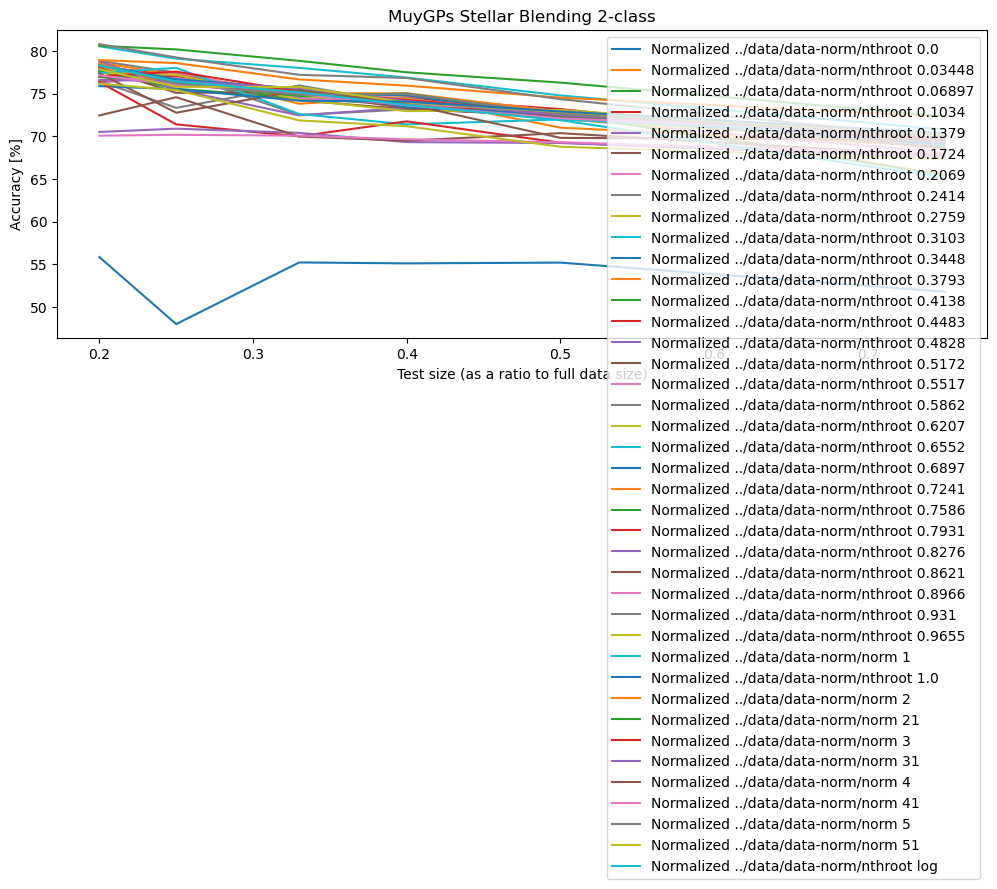

In [10]:
plt.figure(figsize=(12,4))

for path in norm_data_names:
    path = '../data/data-norm/' + path
    data = pd.read_csv(path,na_values='-')
    data.fillna(0,inplace=True)
    data_label = 'Normalized {} {}'.format(*path.split('_')[:2])
    plt.plot(accuracies['test_size'].values, accuracies[data_label].values, label=data_label)

plt.title("MuyGPs Stellar Blending 2-class")    
plt.legend(fontsize=10)   
plt.tick_params(labelsize=10)
plt.xlabel("Test size (as a ratio to full data size)", fontsize=10)
plt.ylabel("Accuracy [%]", fontsize=10)
plt.savefig("muygps_.png")
plt.show()